In [70]:
localfileName = "f-37"

In [71]:
import ee
import sys
sys.path.insert(1, "../apGIS/")
import apgis
from apgis.apgeojson import GeoJSON
from apgis.apfield import Field
import apgis.geespatial as spatial
from apgis.apdate import Date
import apgis.apexception as apexception 

In [72]:
import geemap
Map = geemap.Map()
Map.add_basemap("SATELLITE")

In [73]:
vis = {
    'min': 0, 
    'max': 10, 
    'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', 
                '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']
}


In [74]:
drange = (Date("2020-01-01"), Date("2020-01-31"))
field = Field(localfile=f"{localfileName}.geojson")

S2 = apgis.gee.genCollection(sensor="L2A", daterange=drange, geometry=field.eeROI)\
#.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 15))

print(S2.size().getInfo())

7


In [75]:
print(spatial.getArea(ee.Geometry(field.geometry), "HA"))

2.475


In [76]:
image = S2.first().clip(field.eeROI)
print(image.date().getInfo())

{'type': 'Date', 'value': 1577855711222}


In [77]:
ndvi = apgis.index.generateIndex(image=image, sensor="L2A", index="NDVI").clip(field.eeAOI)
ndmi = apgis.index.generateIndex(image=image, sensor="L2A", index="NDMI").clip(spatial.genBufferGeo(field, 50))

In [78]:
ndviRender = spatial.renderNDVI(ndvi)
ndviRender.getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDVI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [16, 21],
   'origin': [9929, 8982],
   'crs': 'EPSG:32644',
   'crs_transform': [10, 0, 300000, 0, -10, 1500000]}]}

In [79]:
# Map.addLayer(ndviRender, vis, "ndvi")
# Map.centerObject(field.eeAOI,18)

In [80]:
# Map

In [81]:
ndviLayerRender = spatial.layerCoding(ndviRender)
# Map.addLayer(ndviLayerRender, {}, "ndvi layers")

In [82]:
ndviLayerRender.getInfo()

{'type': 'FeatureCollection',
 'columns': {'count': 'Long<0, 4294967295>',
  'label': 'Integer',
  'layerID': 'Float',
  'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'geodesic': False,
    'type': 'Polygon',
    'coordinates': [[[80.07239873677409, 12.752718597151471],
      [80.07282245767232, 12.752720083340995],
      [80.07282242476522, 12.752729125036954],
      [80.07296980596497, 12.752729641813703],
      [80.07296977306308, 12.752738683510035],
      [80.07311715427454, 12.752739200205038],
      [80.07311712137786, 12.75274824190174],
      [80.073264502601, 12.752748758514999],
      [80.07326446970953, 12.752757800212075],
      [80.07341185094438, 12.752758316743586],
      [80.0734118180581, 12.752767358441032],
      [80.07355919930465, 12.752767874890798],
      [80.07355916642359, 12.752776916588617],
      [80.07370654768182, 12.752777432956636],
      [80.07370608741735, 12.752904016730739],
      [80.07369687608393, 12.752903984459811

In [83]:
ndviLayerRender.size().getInfo()

1

In [84]:
layers = [int(float(i)) for i in ndviLayerRender.aggregate_histogram("layerID").getInfo().keys()]

In [85]:
layers = list(set(layers))
layers

[0]

In [17]:
featureList = []
for layer in layers:
    filterLayer = ee.Filter.rangeContains(field="layerID", minValue=layer, maxValue=layer)
    layerCollection = ndviLayerRender.filter(filterLayer)
    count = layerCollection.first().get("count")
    layerFeature = layerCollection.union(5).first().setMulti({"layerID":layer, "count": count})
    featureList.append(layerFeature)

In [18]:
ndvicount = ee.FeatureCollection(featureList)
ndvicount.getInfo()

{'type': 'FeatureCollection',
 'columns': {'count': 'Long', 'layerID': 'Integer', 'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[79.03806976561957, 10.899847444723644],
       [79.03811549241874, 10.89984773746663],
       [79.03811543318383, 10.899856776198236],
       [79.0381337239071, 10.899856893293634],
       [79.03813366467219, 10.899865932025241],
       [79.03814281003382, 10.899865990568447],
       [79.03814275079891, 10.899875029300057],
       [79.03815189616054, 10.899875087843265],
       [79.03815165921193, 10.899911242769695],
       [79.0381425138413, 10.899911184226488],
       [79.03814245460639, 10.899920222958094],
       [79.03813330924476, 10.899920164405906],
       [79.03813325000985, 10.899929203137512],
       [79.0381149592776, 10.899929086042116],
       [79.03811490004269, 10.899938124773726],
       [79.03806917322555, 10.89993783203074],
       [79.03806976561957, 10.899847444

In [19]:
ndvicount.size().getInfo()

5

In [20]:
ndvicount.aggregate_histogram("count").getInfo()

{'254': 1, '3': 1, '52': 1, '634': 1, '91': 1}

In [21]:
import matplotlib.pyplot as plt

In [22]:
labels = ["Barren", "Critical", "Less critical", "Needs attention", "Healthy vegetation"]

In [23]:
keys = ndvicount.aggregate_array("layerID").getInfo()

In [24]:
values = ndvicount.aggregate_array("count").getInfo()

In [25]:
keys

[0, 1, 2, 3, 4]

In [26]:
values

[634, 254, 91, 3, 52]

In [27]:
newkey,newval =[], []
summ = 0
for index, (key, val) in enumerate(zip(keys,values)):
    if index < 4:
        newkey.append(key)
        newval.append(val)
    else:
        summ += val
newval.append(summ)
newkey.append(5)

In [28]:
newval

[634, 254, 91, 3, 52]

In [29]:
newkey

[0, 1, 2, 3, 5]

In [30]:
explode = (0.1, 0.1, 0.1, 0.1, 0.1)

In [31]:
colors = ( "brown", "red","orange", "yellow", "green") 
wp = { 'linewidth' : 1, 'edgecolor' : "black" } 

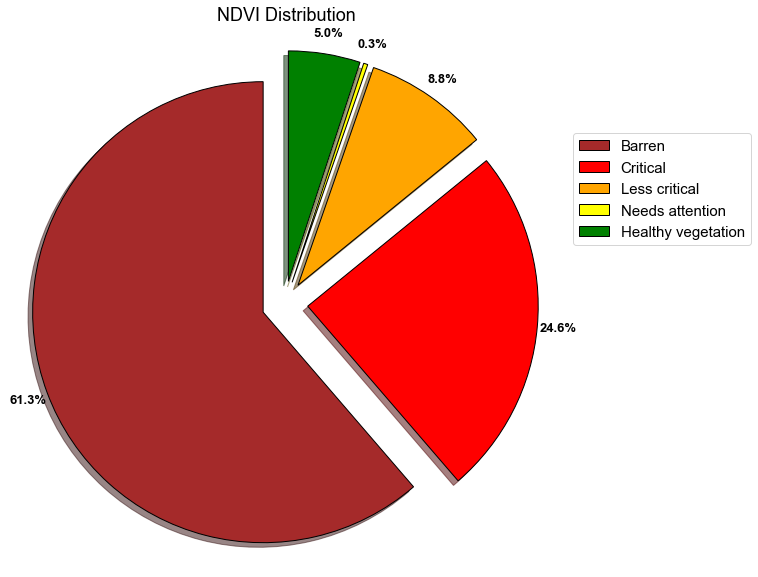

In [69]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=15


fig1, ax1 = plt.subplots(figsize=(10,10))
wedges, texts, autotexts = ax1.pie(newval, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, wedgeprops =wp, pctdistance=1.09, labeldistance=1.7)
ax1.axis('equal') 

ax1.legend(wedges, labels, 
          loc ="center left", 
          bbox_to_anchor =(1, 0, 0.5, 1.4)) 
  
plt.setp(autotexts, size = 13, weight ="bold") 
ax1.set_title("NDVI Distribution") 

plt.show()

In [48]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [33]:
ndviLayerCol = spatial.mergeLayerPolygons(ndvicount)
# Map.addLayer(ndviLayerCol, {}, "ndvi layers col")

In [34]:
ndviLayerCol.size().getInfo()

5

In [35]:
ndviLayerCol.getInfo()

{'type': 'FeatureCollection',
 'columns': {'layerID': 'Integer', 'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[79.03806976561957, 10.899847444723644],
       [79.03811549241874, 10.89984773746663],
       [79.03811543318383, 10.899856776198236],
       [79.0381337239071, 10.899856893293634],
       [79.03813366467219, 10.899865932025241],
       [79.03814281003382, 10.899865990568447],
       [79.03814275079891, 10.899875029300057],
       [79.03815189616054, 10.899875087843265],
       [79.03815165921193, 10.899911242769695],
       [79.0381425138413, 10.899911184226488],
       [79.03814245460639, 10.899920222958094],
       [79.03813330924476, 10.899920164405906],
       [79.03813325000985, 10.899929203137512],
       [79.0381149592776, 10.899929086042116],
       [79.03811490004269, 10.899938124773726],
       [79.03806917322555, 10.89993783203074],
       [79.03806976561957, 10.899847444723644]]],
     [

In [36]:
indexes = ndvi.addBands(ndmi)
rawData = spatial.accumulateRawValue(indexes, field)
scoredData = spatial.scoreBuilder(rawData)

In [37]:
rawData.getInfo()

{'type': 'FeatureCollection',
 'columns': {'NDMI': 'Float', 'NDVI': 'Float', 'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03820250325404, 10.900526227757593]},
   'id': '0',
   'properties': {'NDMI': 0.2105700522661209, 'NDVI': 0.26766446232795715}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03829395708064, 10.900526813226236]},
   'id': '1',
   'properties': {'NDMI': 0.19414633512496948, 'NDVI': 0.25153374671936035}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03838541091247, 10.900527398667625]},
   'id': '2',
   'properties': {'NDMI': 0.21804985404014587, 'NDVI': 0.23559539020061493}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03847686474948, 10.900527984081762]},
   'id': '3',
   'properties': {'NDMI': 0.218722403049469, 'NDVI': 0.22123894095420837}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',


In [38]:
scoredData.getInfo()

{'type': 'FeatureCollection',
 'columns': {'NDMI': 'Float', 'NDVI': 'Float', 'system:index': 'String'},
 'properties': {'NDMI Mean': 0.18, 'NDVI Mean': 0.17, 'NDVI Score': 0},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03820250325404, 10.900526227757593]},
   'id': '0',
   'properties': {'NDMI': 0.2105700522661209, 'NDVI': 0.26766446232795715}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03829395708064, 10.900526813226236]},
   'id': '1',
   'properties': {'NDMI': 0.19414633512496948, 'NDVI': 0.25153374671936035}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03838541091247, 10.900527398667625]},
   'id': '2',
   'properties': {'NDMI': 0.21804985404014587, 'NDVI': 0.23559539020061493}},
  {'type': 'Feature',
   'geometry': {'type': 'Point',
    'coordinates': [79.03847686474948, 10.900527984081762]},
   'id': '3',
   'properties': {'NDMI': 0.218722403049469, 'NDVI': 0.2212